## Import Libraries

In [140]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import matplotlib
import matplotlib.patches as mpatches
#import shap
import os
import pandas as pd
#improve gpu memory usage
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [141]:
# Set matplotlib default color cycle
new_color_cycle = [
#jjJZ4
    '#4f2ca8',
#A14N23LO
    '#b45f06',
#HAHMggf
    '#ff0000',
#qqa
    '#d4d400',
#ZZ4lep
    '#294a18',
#Zprime2EJs
    '#00de00',
#HHbbttHadHad
    '#5b0f00',
#jjJZ2
  '#ca7dff',
#jjJZ1
  '#d201d2',
#data
 '#3232ff', 
#zerobias
    '#002a75',
#passedHLT
    '#00cdcd',
#jjJZ124
    '#8e1d55',
#test 2
    '#7f7f7f'
]

# You can then apply this new color cycle to your matplotlib plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=new_color_cycle)

## Read Data Files

In [142]:
# This is the list that will hold all of the data (data22 and MC)

datasets = {}

In [143]:
# Read MC data.

data_path = '/home/jovyan/MC_data/'

for filename in os.listdir(data_path):

    if filename.startswith('N') or filename.startswith('.'): continue

    dataset_tag = filename.split('_')[0]
    
    with h5py.File(data_path+filename, 'r') as hf:
        HLT_jets = hf['HLT_jets'][:]
        L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
        L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
        HLT_electrons = hf['HLT_electrons'][:]
        LRT_electrons = hf['LRT_electrons'][:]
        L1_egammas = hf['L1_egammas'][:]
        HLT_muons = hf['HLT_muons'][:]
        LRT_muons = hf['LRT_muons'][:]
        L1_muons = hf['L1_muons'][:]
        L1_eFex_taus = hf['L1_eFex_taus'][:]
        L1_jFex_taus = hf['L1_jFex_taus'][:]
        HLT_photons = hf['HLT_photons'][:]
        HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 4)  # Broadcasting MET
        L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
        pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
        pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]

        HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons[:, :3, [0, 2, 3]], HLT_muons[:, :3, [0, 2, 3]], HLT_photons[:, :3, [0, 2, 3]], HLT_MET[:, :, [0, 2, 3]]], axis=1)
        L1_objects = np.concatenate([L1_jFexSR_jets[:, :, :], L1_egammas[:, :3, :], L1_muons[:, :3, :], L1_eFex_taus[:, :3, :], L1_MET], axis=1)
        
        datasets[dataset_tag] = {
            'HLT_data': HLT_objects,
            'L1_data': L1_objects,
            'passL1': pass_L1_unprescaled==1,
            'passHLT': pass_HLT_unprescaled==1,
            'HLTweights': np.ones(len(HLT_objects)),
            'L1weights': np.ones(len(L1_objects)),
        }

        if len(HLT_objects) > 100000:
            datasets[dataset_tag] = {key: value[:100000] for key, value in datasets[dataset_tag].items()}

In [144]:
# Read 2024 EB data

with h5py.File('/home/jovyan/EB_data/EB_ntuples_08-13-2024-003.h5', 'r') as hf:
    HLT_jets = hf['HLT_jets'][:]
    ofl_jets = hf['ofl_jets'][:]
    L1_jFexSR_jets = hf['L1_jFexSR_jets'][:]
    L1_jFexLR_jets = hf['L1_jFexLR_jets'][:]
    HLT_electrons = hf['HLT_electrons'][:]
    LRT_electrons = hf['LRT_electrons'][:]
    ofl_electrons = hf['ofl_electrons'][:]
    L1_egammas = hf['L1_egammas'][:]
    HLT_muons = hf['HLT_muons'][:]
    LRT_muons = hf['LRT_muons'][:]
    ofl_muons = hf['ofl_muons'][:]
    L1_muons = hf['L1_muons'][:]
    L1_eFex_taus = hf['L1_eFex_taus'][:]
    L1_jFex_taus = hf['L1_jFex_taus'][:]
    HLT_photons = hf['HLT_photons'][:]
    ofl_photons = hf['ofl_photons'][:]
    HLT_MET = hf['HLT_MET'][:].reshape(-1, 1, 3)  # Broadcasting MET
    L1_MET = hf['L1_MET'][:].reshape(-1, 1, 3)
    pass_L1_unprescaled = hf["pass_L1_unprescaled"][:]
    pass_HLT_unprescaled = hf["pass_HLT_unprescaled"][:]
    EB_weights = hf["EB_weights"][:]
    event_number = hf["event_number"][:]
    run_number = hf["run_number"][:]

HLT_objects = np.concatenate([HLT_jets[:, :, [0, 2, 3]], HLT_electrons[:, :3, :], HLT_muons[:, :3, :], HLT_photons[:, :3, :], HLT_MET], axis=1)
L1_objects = np.concatenate([L1_jFexSR_jets[:, :, :], L1_egammas[:, :3, :], L1_muons[:, :3, :], L1_eFex_taus[:, :3, :], L1_MET], axis=1)



# Indices of events that passed L1
pass_L1_idxs = (pass_L1_unprescaled == 1)

# Indices of events that passed HLT
pass_HLT_idxs = (pass_HLT_unprescaled == 1)



datasets['EB_data'] = {
    'HLT_data': HLT_objects[pass_L1_idxs] ,
    'L1_data': L1_objects[pass_L1_idxs] ,
    'passL1': pass_L1_idxs[pass_L1_idxs],
    'passHLT': pass_HLT_idxs[pass_L1_idxs],
    'HLTweights': EB_weights[pass_L1_idxs],
    'L1weights': EB_weights[pass_L1_idxs],
}

datasets['EB_zerobias'] = {
    'HLT_data': HLT_objects[~pass_L1_idxs] ,
    'L1_data': L1_objects[~pass_L1_idxs] ,
    'passL1': pass_L1_idxs[~pass_L1_idxs],
    'passHLT': pass_HLT_idxs[~pass_L1_idxs],
    'HLTweights': EB_weights[~pass_L1_idxs],
    'L1weights': EB_weights[~pass_L1_idxs],
}

datasets['EB_passHLT'] = {
    'HLT_data': HLT_objects[pass_HLT_idxs] ,
    'L1_data': L1_objects[pass_HLT_idxs] ,
    'passL1': pass_L1_idxs[pass_HLT_idxs],
    'passHLT': pass_HLT_idxs[pass_HLT_idxs],
    'HLTweights': EB_weights[pass_HLT_idxs],
    'L1weights': EB_weights[pass_HLT_idxs],
}
    

## Data Processing

In [145]:
#change jjJZ4 weights
temp = np.zeros(len(datasets['jjJZ4']['HLTweights']))
for i in range (len(datasets['jjJZ4']['HLTweights'])):
    temp[i] = 0.05
datasets['jjJZ4']['HLTweights'] = temp
temp = np.zeros(len(datasets['jjJZ4']['L1weights']))
for i in range (len(datasets['jjJZ4']['L1weights'])):
    temp[i] = 0.5
datasets['jjJZ4']['L1weights'] = temp

In [146]:
#create combo of jjJZ4 & jjJZ2 & jjJZ1

datasets['jjJZ1&2&4'] = {
    'HLT_data': np.concatenate((datasets['jjJZ1']['HLT_data'],datasets['jjJZ2']['HLT_data'],datasets['jjJZ4']['HLT_data'])),
    'L1_data': np.concatenate((datasets['jjJZ1']['L1_data'],datasets['jjJZ2']['L1_data'],datasets['jjJZ4']['L1_data'])) ,
    'passL1': np.concatenate((datasets['jjJZ1']['passL1'],datasets['jjJZ2']['passL1'],datasets['jjJZ4']['passL1'])),
    'passHLT': np.concatenate((datasets['jjJZ1']['passHLT'],datasets['jjJZ2']['passHLT'],datasets['jjJZ4']['passHLT'])),
    'HLTweights': np.concatenate((datasets['jjJZ1']['HLTweights'],datasets['jjJZ2']['HLTweights'],datasets['jjJZ4']['HLTweights'])),
    'L1weights': np.concatenate((datasets['jjJZ1']['L1weights'],datasets['jjJZ2']['L1weights'],datasets['jjJZ4']['L1weights'])),
}

In [147]:
#change jjJZ4 weights
temp = np.zeros(len(datasets['jjJZ4']['HLTweights']))
for i in range (len(datasets['jjJZ4']['HLTweights'])):
    temp[i] = 1
datasets['jjJZ4']['HLTweights'] = temp
temp = np.zeros(len(datasets['jjJZ4']['L1weights']))
for i in range (len(datasets['jjJZ4']['L1weights'])):
    temp[i] = 1
datasets['jjJZ4']['L1weights'] = temp

In [148]:
#create combo of eb and dijets

datasets['eb_dijet'] = datasets['EB_data']

In [149]:
#change weights of eb
temp = np.zeros(len(datasets['eb_dijet']['HLTweights']))
sum1 = 0
for data in datasets['eb_dijet']['HLTweights']:
    sum1+= data
for i in range(len(datasets['eb_dijet']['HLTweights'])):
    temp[i] = (datasets['eb_dijet']['HLTweights'][i])*len(datasets['eb_dijet']['HLTweights'])/2/sum1
datasets['eb_dijet']['HLTweights'] = temp

temp = np.zeros(len(datasets['eb_dijet']['L1weights']))
sum1 = 0
for data in datasets['eb_dijet']['L1weights']:
    sum1+= data
for i in range(len(datasets['eb_dijet']['L1weights'])):
    temp[i] = 0.5
datasets['eb_dijet']['L1weights'] = temp

In [150]:
#create combo of eb and dijets

datasets['eb_dijet'] = {
    'HLT_data': np.concatenate((datasets['eb_dijet']['HLT_data'],datasets['jjJZ1&2&4']['HLT_data'])),
    'L1_data': np.concatenate((datasets['eb_dijet']['L1_data'],datasets['jjJZ1&2&4']['L1_data'])),
    'passL1': np.concatenate((datasets['eb_dijet']['passL1'],datasets['jjJZ1&2&4']['passL1'])),
    'passHLT': np.concatenate((datasets['eb_dijet']['passHLT'],datasets['jjJZ1&2&4']['passHLT'])),
    'HLTweights': np.concatenate((datasets['eb_dijet']['HLTweights'],datasets['jjJZ1&2&4']['HLTweights'])),
    'L1weights': np.concatenate((datasets['eb_dijet']['L1weights'],datasets['jjJZ1&2&4']['L1weights'])),

}

In [151]:
"""Multiply the et of the L1 muons by 1000 to get them into the right units."""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label == 'L1_data':
            data[:, 13:16, 0] *= 1000

In [152]:
# Zero out jets below 50GeV
for tag, dict in datasets.items():
    
    HLT_lowpt_mask = dict['HLT_data'][:, :10, 0] < 50
    dict['HLT_data'][:, :10][HLT_lowpt_mask] = 0

    #L1_lowpt_mask = dict['L1_data'][:, :10, 0] < 50
    #dict['L1_data'][:, :10][L1_lowpt_mask] = 0

In [153]:
# Split EB data in train, test

random_seed = 789247

indicesHLT = np.arange(len(datasets['eb_dijet']['HLT_data']))
train_indices, _indices = train_test_split(indices, train_size=0.5, random_state=random_seed)
test1_indices, test2_indices = train_test_split(_indices, train_size=0.5, random_state=random_seed)

datasets['ebdijet_train'] = {key:value[train_indices] for key, value in datasets['eb_dijet'].items()}
datasets['ebdijet_test1'] = {key:value[test1_indices] for key, value in datasets['eb_dijet'].items()}
datasets['ebdijet_test2'] = {key:value[test2_indices] for key, value in datasets['eb_dijet'].items()}


del datasets['eb_dijet']

In [154]:
#save pt values before normalization for 2d histogram of max pt vs. anomaly score
HLT_max_pt_vals = {}
for tag,dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['HLT_data']))
    for i in range(len(datasets[tag]['HLT_data'])):
        for j in range(20):
            if temp[i] < datasets[tag]['HLT_data'][i,j,0]:
                temp[i] = datasets[tag]['HLT_data'][i,j,0]
    HLT_max_pt_vals[tag] = temp


L1_max_pt_vals = {}
for tag,dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['L1_data']))
    for i in range(len(datasets[tag]['L1_data'])):
        for j in range(20):
            if temp[i] < datasets[tag]['L1_data'][i,j,0]:
                temp[i] = datasets[tag]['L1_data'][i,j,0]
    L1_max_pt_vals[tag] = temp



HLT_jet_mults = {}
for tag,dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['HLT_data']))
    for i in range(len(datasets[tag]['HLT_data'])):
        for j in range(10):
            if datasets[tag]['HLT_data'][i][j][0] > 0:
                temp[i] += 1
    HLT_jet_mults[tag] = temp


L1_jet_mults = {}
for tag,dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['L1_data']))
    for i in range(len(datasets[tag]['L1_data'])):
        for j in range(10):
            if datasets[tag]['L1_data'][i][j][0] > 0:
                temp[i] += 1
    L1_jet_mults[tag] = temp

 
HLT_electron_mults = {}
for tag, dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['HLT_data']))
    for i in range(len(datasets[tag]['HLT_data'])):
        for j in range(10,13):
            if datasets[tag]['HLT_data'][i][j][0] > 0:
                temp[i] += 1
    HLT_electron_mults[tag] = temp

L1_electron_mults = {}
for tag, dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['L1_data']))
    for i in range(len(datasets[tag]['L1_data'])):
        for j in range(10,13):
            if datasets[tag]['L1_data'][i][j][0] > 0:
                temp[i] += 1
    L1_electron_mults[tag] = temp

HLT_muon_mults = {}
for tag, dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['HLT_data']))
    for i in range(len(datasets[tag]['HLT_data'])):
        for j in range(13,16):
            if datasets[tag]['HLT_data'][i][j][0] > 0:
                temp[i] += 1
    HLT_muon_mults[tag] = temp

L1_muon_mults = {}
for tag, dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['L1_data']))
    for i in range(len(datasets[tag]['L1_data'])):
        for j in range(13,16):
            if datasets[tag]['L1_data'][i][j][0] > 0:
                temp[i] += 1
    L1_muon_mults[tag] = temp

HLT_photon_mults = {}
for tag, dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['HLT_data']))
    for i in range(len(datasets[tag]['HLT_data'])):
        for j in range(16,19):
            if datasets[tag]['HLT_data'][i][j][0] > 0:
                temp[i] += 1
    HLT_photon_mults[tag] = temp

L1_photon_mults = {}
for tag, dict in datasets.items():
    temp = np.zeros(len(datasets[tag]['L1_data']))
    for i in range(len(datasets[tag]['L1_data'])):
        for j in range(16,19):
            if datasets[tag]['L1_data'][i][j][0] > 0:
                temp[i] += 1
    L1_photon_mults[tag] = temp

In [155]:
for tag, dict in datasets.items():
    print(f'\n{tag}:')
    for key, value in dict.items():
        print(f'{key}: {value.shape}')


jjJZ4:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
HLTweights: (100000,)
L1weights: (100000,)

A14N23LO:
HLT_data: (10000, 20, 3)
L1_data: (10000, 20, 3)
passL1: (10000,)
passHLT: (10000,)
HLTweights: (10000,)
L1weights: (10000,)

HAHMggfZdZd2l2nu:
HLT_data: (70000, 20, 3)
L1_data: (70000, 20, 3)
passL1: (70000,)
passHLT: (70000,)
HLTweights: (70000,)
L1weights: (70000,)

qqa:
HLT_data: (50000, 20, 3)
L1_data: (50000, 20, 3)
passL1: (50000,)
passHLT: (50000,)
HLTweights: (50000,)
L1weights: (50000,)

ZZ4lep:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
HLTweights: (100000,)
L1weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
HLTweights: (100000,)
L1weights: (100000,)

HHbbttHadHad:
HLT_data: (100000, 20, 3)
L1_data: (100000, 20, 3)
passL1: (100000,)
passHLT: (100000,)
HLTweights: (100000,)
L1weights: (100000,)

jjJZ2:
HLT_data: (1

In [156]:
"""Met bias. For some events, MET was not calculated, so was written as -999.
We don't want this to impact training, so we map 0 --> 0.001 and -999 --> 0"""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):

            # MET: 0 --> 0.001 and -999 --> 0 and nan --> 0
            MET_zeros = (data[:, 19, 0] == 0) # indices where MET=0
            MET_999 = ((data[:, 19, 0] == -999)) # indices where MET=-999 (not calculated)
            MET_nan = np.isnan(data[:, 19, 2])
            data[MET_zeros, 19, 0] = 0.001
            data[MET_999, 19, :] = 0
            data[MET_nan, 19, :] = 0

In [157]:
# Change phi --> delta phi between leading jet
def dphi(phi1, phi2):
    return np.mod(phi1 - phi2 + np.pi, 2 * np.pi) - np.pi # accounts for periodicity of phi

for tag, dict in datasets.items():
    for data_type in ['HLT', 'L1']:

        # Create a mask for zeroed-out objects (where pt is zero)
        zeroed_mask = dict[data_type+'_data'][:, :, 0] == 0

        # Find phi of the leading jets in each event
        leading_jet_phi = dict[data_type+'_data'][:, 0, 2]

        # Duplicate along the third dimension such that it has the right shape
        leading_jet_phi = np.tile(leading_jet_phi, (20, 1)).T

        # update dphi for all objects
        dict[data_type+'_data'][:, :, 2] = dphi(phi1=dict[data_type+'_data'][:, :, 2], phi2=leading_jet_phi)

        # Reset phi of zeroed-out objects to zero
        dict[data_type+'_data'][zeroed_mask, 2] = 0

In [158]:

"""Normalize pt such that sum(pt) = 10 in each event"""
for tag, dict in datasets.items():
    for label, data in dict.items():
        if label == 'HLT_data':
#             # sum of the pt and E in each event
            sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)
        
#             # If the sum is 0, set the sum to 1 to avoid division by 0
            sum_pt[sum_pt == 0] = 1
        
#             # Divide pt and E by their respective sums, multiply by 10
            data[:, :, 0] *= (100/sum_pt) 
        if label == 'L1_data':
#             # sum of the pt and E in each event
            sum_pt = np.sum(data[:, :, 0], axis=1, keepdims=True)
        
#             # If the sum is 0, set the sum to 1 to avoid division by 0
            sum_pt[sum_pt == 0] = 1
        
#             # Divide pt and E by their respective sums, multiply by 10
            data[:, :, 0] *= (1/sum_pt) 


## Autoencoder Architecture

In [159]:
# Flatten ndarrays for use in DNN

for tag, dict in datasets.items():
    for label, data in dict.items():
        if label.endswith('data'):
            datasets[tag][label] = np.reshape(data, newshape=(-1, 60))

# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


jjJZ4:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
HLTweights: (100000,)
L1weights: (100000,)

A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
HLTweights: (10000,)
L1weights: (10000,)

HAHMggfZdZd2l2nu:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
HLTweights: (70000,)
L1weights: (70000,)

qqa:
HLT_data: (50000, 60)
L1_data: (50000, 60)
passL1: (50000,)
passHLT: (50000,)
HLTweights: (50000,)
L1weights: (50000,)

ZZ4lep:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
HLTweights: (100000,)
L1weights: (100000,)

Zprime2EJs:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
HLTweights: (100000,)
L1weights: (100000,)

HHbbttHadHad:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
HLTweights: (100000,)
L1weights: (100000,)

jjJZ2:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (

In [160]:
def create_AE(input_dim, h_dim_1, h_dim_2, h_dim_3, h_dim_4, latent_dim):
    
     # Encoder
    encoder_inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(h_dim_1, activation='relu')(encoder_inputs)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    x = layers.Dense(h_dim_3, activation='relu')(x)
    x = layers.Dense(h_dim_4, activation='relu')(x)
    z = layers.Dense(latent_dim, activation='relu')(x)
    
    encoder = Model(inputs=encoder_inputs, outputs=z)

    # Decoder
    decoder_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(h_dim_4, activation='relu')(decoder_inputs)
    x = layers.Dense(h_dim_3, activation='relu')(x)
    x = layers.Dense(h_dim_2, activation='relu')(x)
    x = layers.Dense(h_dim_1, activation='relu')(x)
    outputs = layers.Dense(input_dim)(x)

    decoder = Model(inputs=decoder_inputs, outputs=outputs)

    ae_outputs = decoder(encoder(encoder_inputs))
    ae = Model(encoder_inputs, outputs=ae_outputs)

    return ae, encoder, decoder

In [161]:
def loss_fn(y_true, y_pred):
    """masked mse"""
    # mask0 = K.cast(K.not_equal(y_true, 0), K.floatx())
    # maskMET = K.cast(K.not_equal(y_true, -999), K.floatx())
    # mask = mask0 * maskMET
    # squared_difference = K.square(mask * (y_pred - y_true))
    squared_difference = K.square((y_pred - y_true))
    return K.mean(squared_difference)

In [162]:
# Initialize models
INPUT_DIM = datasets['ebdijet_train']['HLT_data'].shape[1]
H_DIM_1 = 100
H_DIM_2 = 100
H_DIM_3 = 64
H_DIM_4 = 32
LATENT_DIM = 4

HLT_AE, HLT_encoder, HLT_decoder = create_AE(INPUT_DIM, H_DIM_1, H_DIM_2, H_DIM_3, H_DIM_4, LATENT_DIM)
L1_AE, L1_encoder, L1_decoder = create_AE(INPUT_DIM, H_DIM_1, H_DIM_2, H_DIM_3, H_DIM_4, LATENT_DIM)

HLT_AE.summary()
L1_AE.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_25 (Functional)      │ (None, 4)              │        24,876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_27 (Functional)      │ (None, 60)             │        24,932 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,808 (194.56 KB)

 Trainable params: 49,808 (194.56 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_31 (Functional)      │ (None, 4)              │        24,876 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_33 (Functional)      │ (None, 60)             │        24,932 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,808 (194.56 KB)

 Trainable params: 49,808 (194.56 KB)

 Non-trainable params: 0 (0.00 B)

In [163]:
HLT_AE.compile(optimizer='adam', loss=loss_fn)
L1_AE.compile(optimizer='adam', loss=loss_fn)

In [164]:
# Define callbacks: early stopping and learning rate scheduler

STOP_PATIENCE = 6
LR_PATIENCE = 4

early_stopping = EarlyStopping(patience=STOP_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=LR_PATIENCE, verbose=1)

callbacks = [early_stopping, reduce_lr]

In [165]:
NUM_EPOCHS = 200
BATCH_SIZE = 512

In [166]:
HLT_AE.compile(optimizer='adam', loss=loss_fn)
L1_AE.compile(optimizer='adam', loss=loss_fn)

## Model Training

In [167]:
# train HLT model
history = HLT_AE.fit(
    x=datasets['ebdijet_train']['HLT_data'], 
    y=datasets['ebdijet_train']['HLT_data'], 
    validation_split=0.15, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks, 
    sample_weight = datasets['ebdijet_train']['HLTweights']
)

Epoch 1/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 7.2550 - val_loss: 0.9200 - learning_rate: 0.0010
Epoch 2/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.9215 - val_loss: 0.7616 - learning_rate: 0.0010
Epoch 3/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7766 - val_loss: 0.6909 - learning_rate: 0.0010
Epoch 4/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.7011 - val_loss: 0.6420 - learning_rate: 0.0010
Epoch 5/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6691 - val_loss: 0.6266 - learning_rate: 0.0010
Epoch 6/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.6263 - val_loss: 0.5783 - learning_rate: 0.0010
Epoch 7/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5937 - val_loss: 0.5719 - learning_rate: 0.0010
Epoch 8/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5628 - val_loss: 0.5335 - learning_rate: 0.0010
Epoch 9/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5491 - val_loss: 0.5179 - learning_rate: 0.0010
E

In [168]:
HLT_AE.save_weights('/home/jovyan/Keras_weights/Weights_HLT_AE.weights.h5')
HLT_encoder.save_weights('/home/jovyan/Keras_weights/Weights_HLT_encoder.weights.h5')
HLT_AE.load_weights('/home/jovyan/Keras_weights/Weights_HLT_AE.weights.h5')
HLT_encoder.load_weights('/home/jovyan/Keras_weights/Weights_HLT_encoder.weights.h5')

In [169]:
# train L1 model
# train HLT model
history = L1_AE.fit(
    x=datasets['ebdijet_train']['L1_data'], 
    y=datasets['ebdijet_train']['L1_data'], 
    validation_split=0.15, 
    epochs=NUM_EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=callbacks, 
    sample_weight = datasets['ebdijet_train']['L1weights']
)

Epoch 1/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.5224 - val_loss: 0.4406 - learning_rate: 0.0010
Epoch 2/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4343 - val_loss: 0.4206 - learning_rate: 0.0010
Epoch 3/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4196 - val_loss: 0.4118 - learning_rate: 0.0010
Epoch 4/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4114 - val_loss: 0.4072 - learning_rate: 0.0010
Epoch 5/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4052 - val_loss: 0.4053 - learning_rate: 0.0010
Epoch 6/200
750/750 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4028 - val_loss: 0.3988 - learning_rate: 0.0010


In [170]:
L1_AE.save_weights('/home/jovyan/Keras_weights/Weights_L1_AE.weights.h5')
L1_encoder.save_weights('/home/jovyan/Keras_weights/Weights_L1_encoder.weights.h5')
L1_AE.load_weights('/home/jovyan/Keras_weights/Weights_L1_AE.weights.h5')
L1_encoder.load_weights('/home/jovyan/Keras_weights/Weights_L1_encoder.weights.h5')

## Model Evaluation

In [171]:
# Pass the datasets through the model

for tag, dict in datasets.items():
    if tag == 'ebdijet_train': continue

    dict['HLT_model_outputs'] = HLT_AE.predict(dict['HLT_data'])
    #dict['HLT_latent_reps'] = HLT_encoder.predict(dict['HLT_data'])
    dict['L1_model_outputs'] = L1_AE.predict(dict['L1_data'])
    #dict['L1_latent_reps'] = L1_encoder.predict(dict['L1_data'])

3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 579us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 579us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 581us/step
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 579us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 586us/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 579us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 574us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 581us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 585us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 595us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 585us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 578us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 587us/step
18859/18859 ━━━━━━━━━━━━━━━━━━━━ 12s 624us/step
18859/18859 ━━━━━━━━━━━━━━━━━━━━ 12s 621us/step
46918/46918 ━━━━━━━━━━━━━━━━━━━━ 29s 609us/step
46918/46918 ━━━━━━━━━━━━━━━━━━━━ 28s 597us/step
477/47

In [172]:
def mse_loss(true, prediction):
    loss = np.mean(np.square(true - prediction), axis=-1)
    return loss

In [173]:
def MSE_AD_score(y, x):
    return (mse_loss(y, x))

In [174]:
# Calculate the AD scores

for tag, dict in datasets.items():
    if tag == 'ebdijet_train': continue

    dict['HLT_AD_scores'] = MSE_AD_score(dict['HLT_data'], dict['HLT_model_outputs'])
    dict['L1_AD_scores'] = MSE_AD_score(dict['L1_data'], dict['L1_model_outputs'])

In [175]:
# Display the structure of updated datasets
for tag, data in datasets.items():
    print(f'\n{tag}:')
    for key, value in data.items():
        print(f'{key}: {value.shape}')


jjJZ4:
HLT_data: (100000, 60)
L1_data: (100000, 60)
passL1: (100000,)
passHLT: (100000,)
HLTweights: (100000,)
L1weights: (100000,)
HLT_model_outputs: (100000, 60)
L1_model_outputs: (100000, 60)
HLT_AD_scores: (100000,)
L1_AD_scores: (100000,)

A14N23LO:
HLT_data: (10000, 60)
L1_data: (10000, 60)
passL1: (10000,)
passHLT: (10000,)
HLTweights: (10000,)
L1weights: (10000,)
HLT_model_outputs: (10000, 60)
L1_model_outputs: (10000, 60)
HLT_AD_scores: (10000,)
L1_AD_scores: (10000,)

HAHMggfZdZd2l2nu:
HLT_data: (70000, 60)
L1_data: (70000, 60)
passL1: (70000,)
passHLT: (70000,)
HLTweights: (70000,)
L1weights: (70000,)
HLT_model_outputs: (70000, 60)
L1_model_outputs: (70000, 60)
HLT_AD_scores: (70000,)
L1_AD_scores: (70000,)

qqa:
HLT_data: (50000, 60)
L1_data: (50000, 60)
passL1: (50000,)
passHLT: (50000,)
HLTweights: (50000,)
L1weights: (50000,)
HLT_model_outputs: (50000, 60)
L1_model_outputs: (50000, 60)
HLT_AD_scores: (50000,)
L1_AD_scores: (50000,)

ZZ4lep:
HLT_data: (100000, 60)
L1_dat

In [176]:
def ROC_curveL1(dataset, target_rate=10, plot=True):
    """
    Plots ROC curve and returns AUC, TPR, FPR, and thresholds for each dataset.
    
    inputs: 
    dataset: dictionary containing dataset information
    bkg_type: the background type to calculate over
    plot: whether to plot the ROC curve or not
    
    returns:
    results: dictionary {dataset_names: {'TPR': ..., 'AUC': ..., 'FPR': ..., 'threshold': ...}}
    """
    bkg_type = 'L1'
    
    bkg_tag = 'ebdijet_test1'
    #target_rate = 10  # 10 Hz pure rate
    plt.figure(figsize=(8.5,6.8))
    
    results = {}
    
    for tag in dataset.keys():
        if tag != bkg_tag and tag != 'ebdijet_train':
        
            # Combine true labels, anomaly=1 and background=0
            trueVal = np.concatenate((np.ones(dataset[tag][f'{bkg_type}_AD_scores'].shape[0]), np.zeros(dataset[bkg_tag][f'{bkg_type}_AD_scores'].shape[0])))
            
            # Combine predictions from current dataset and background
            predVal_loss = np.concatenate((dataset[tag][f'{bkg_type}_AD_scores'], dataset[bkg_tag][f'{bkg_type}_AD_scores']))
            
            sample_weights = np.concatenate((dataset[tag]['L1weights'], dataset[bkg_tag]['L1weights']))
            
            for i in range(len(predVal_loss)):
                if np.isnan(predVal_loss[i]):
                    predVal_loss[i] = 0
           
            # Calculate ROC curve and AUC, including weights
            fpr_loss, tpr_loss, threshold_loss = sklearn.metrics.roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
            auc_loss = auc(fpr_loss, tpr_loss)

            # Initialize variables for early stopping
            min_diff = float('inf')
            best_idx = 0
            previous_diff = float('inf')
            
            # Iterate over thresholds with early stopping
            for idx, value in enumerate(threshold_loss):
                anomaly_idxs_bkg = dataset[bkg_tag][f'{bkg_type}_AD_scores'] > value
                bkg_rate = 100000 * np.sum(dataset[bkg_tag]['L1weights'] * (anomaly_idxs_bkg & ~dataset[bkg_tag]['passHLT'])) / np.sum(dataset[bkg_tag]['L1weights'])
                # Calculate the difference from the target rate
                diff = abs(bkg_rate - target_rate)
                
                # Check if the difference is decreasing
                if diff < min_diff:
                    min_diff = diff
                    best_idx = idx
                else:
                    # If the difference starts increasing, break the loop
                    if diff > previous_diff:
                        print(f'Background rate = {bkg_rate:.3}Hz')
                        break
                
                previous_diff = diff
            
            # Use the best index found
            selected_threshold = threshold_loss[best_idx]
            selected_fpr = fpr_loss[best_idx]
            signal_tpr = tpr_loss[best_idx]
            
            # Store the results
            results[tag] = {
                'TPR': signal_tpr,
                'AUC': auc_loss,
                'FPR': selected_fpr,
                'threshold': selected_threshold
            }
        
            # Plot ROC curve
            if plot:
                plt.plot(fpr_loss, tpr_loss, "-", label='%s (AUC = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)

    if plot:
        # Set log scale for x and y axis
        plt.semilogx()
        plt.semilogy()
        
        # Plot aesthetics and layout
        plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
        plt.plot([selected_fpr, selected_fpr], [0, 1], '--', color='r')
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.legend(loc='lower right', fontsize=6)
        plt.grid(True)
        plt.tight_layout()
        plt.title(f'Trained over {bkg_type} objects', fontsize=20)
        plt.show()

    return results


In [177]:
def ROC_curveHLT(dataset, target_rate=10, plot=True):
    bkg_type = 'HLT'
    """
    Plots ROC curve and returns AUC, TPR, FPR, and thresholds for each dataset.
    
    inputs: 
    dataset: dictionary containing dataset information
    bkg_type: the background type to calculate over
    plot: whether to plot the ROC curve or not
    
    returns:
    results: dictionary {dataset_names: {'TPR': ..., 'AUC': ..., 'FPR': ..., 'threshold': ...}}
    """
    
    bkg_tag = 'ebdijet_test1'
    #target_rate = 10  # 10 Hz pure rate
    plt.figure(figsize=(8.5,6.8))
    
    results = {}
    
    for tag in dataset.keys():
        if tag != bkg_tag and tag != 'ebdijet_train':
        
            # Combine true labels, anomaly=1 and background=0
            trueVal = np.concatenate((np.ones(dataset[tag][f'{bkg_type}_AD_scores'].shape[0]), np.zeros(dataset[bkg_tag][f'{bkg_type}_AD_scores'].shape[0])))
            
            # Combine predictions from current dataset and background
            predVal_loss = np.concatenate((dataset[tag][f'{bkg_type}_AD_scores'], dataset[bkg_tag][f'{bkg_type}_AD_scores']))
            
            sample_weights = np.concatenate((dataset[tag]['HLTweights'], dataset[bkg_tag]['HLTweights']))
            
            
            for i in range(len(predVal_loss)):
                if np.isnan(predVal_loss[i]):
                    predVal_loss[i] = 0
           
            # Calculate ROC curve and AUC, including weights
            fpr_loss, tpr_loss, threshold_loss = sklearn.metrics.roc_curve(y_true=trueVal, y_score=predVal_loss, sample_weight=sample_weights)
            auc_loss = auc(fpr_loss, tpr_loss)

            # Initialize variables for early stopping
            min_diff = float('inf')
            best_idx = 0
            previous_diff = float('inf')
            
            # Iterate over thresholds with early stopping
            for idx, value in enumerate(threshold_loss):
                anomaly_idxs_bkg = dataset[bkg_tag][f'{bkg_type}_AD_scores'] > value
                bkg_rate = 100000 * np.sum(dataset[bkg_tag]['HLTweights'] * (anomaly_idxs_bkg & ~dataset[bkg_tag]['passHLT'])) / np.sum(dataset[bkg_tag]['HLTweights'])
                # Calculate the difference from the target rate
                diff = abs(bkg_rate - target_rate)
                
                # Check if the difference is decreasing
                if diff < min_diff:
                    min_diff = diff
                    best_idx = idx
                else:
                    # If the difference starts increasing, break the loop
                    if diff > previous_diff:
                        print(f'Background rate = {bkg_rate:.3}Hz')
                        break
                
                previous_diff = diff
            
            # Use the best index found
            selected_threshold = threshold_loss[best_idx]
            selected_fpr = fpr_loss[best_idx]
            signal_tpr = tpr_loss[best_idx]
            
            # Store the results
            results[tag] = {
                'TPR': signal_tpr,
                'AUC': auc_loss,
                'FPR': selected_fpr,
                'threshold': selected_threshold
            }
        
            # Plot ROC curve
            if plot:
                plt.plot(fpr_loss, tpr_loss, "-", label='%s (AUC = %.1f%%)' % (tag, auc_loss*100.), linewidth=1.5)

    if plot:
        # Set log scale for x and y axis
        plt.semilogx()
        plt.semilogy()
        
        # Plot aesthetics and layout
        plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
        plt.plot([selected_fpr, selected_fpr], [0, 1], '--', color='r')
        plt.ylabel("True Positive Rate", fontsize=16)
        plt.xlabel("False Positive Rate", fontsize=16)
        plt.legend(loc='lower right', fontsize=6)
        plt.grid(True)
        plt.tight_layout()
        plt.title(f'Trained over {bkg_type} objects', fontsize=20)
        plt.show()

    return results


TARGET (PURE) RATE::::: 10
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz
Background rate = 10.3Hz


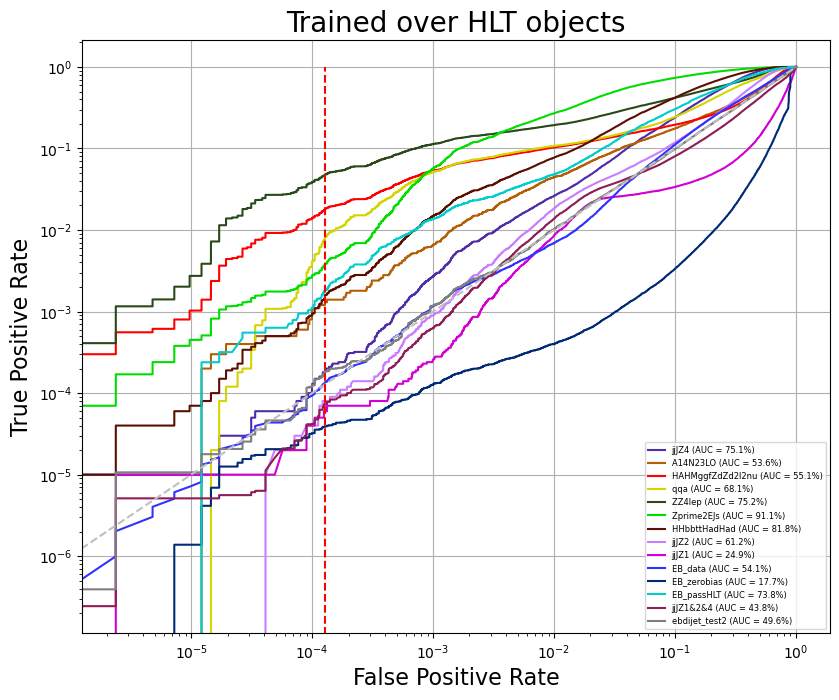

Background rate = 10.5Hz
Background rate = 10.5Hz
Background rate = 10.5Hz
Background rate = 12.7Hz
Background rate = 10.5Hz
Background rate = 10.5Hz
Background rate = 10.5Hz
Background rate = 10.5Hz
Background rate = 10.5Hz
Background rate = 10.5Hz
Background rate = 14.1Hz
Background rate = 17.8Hz
Background rate = 10.5Hz
Background rate = 10.5Hz


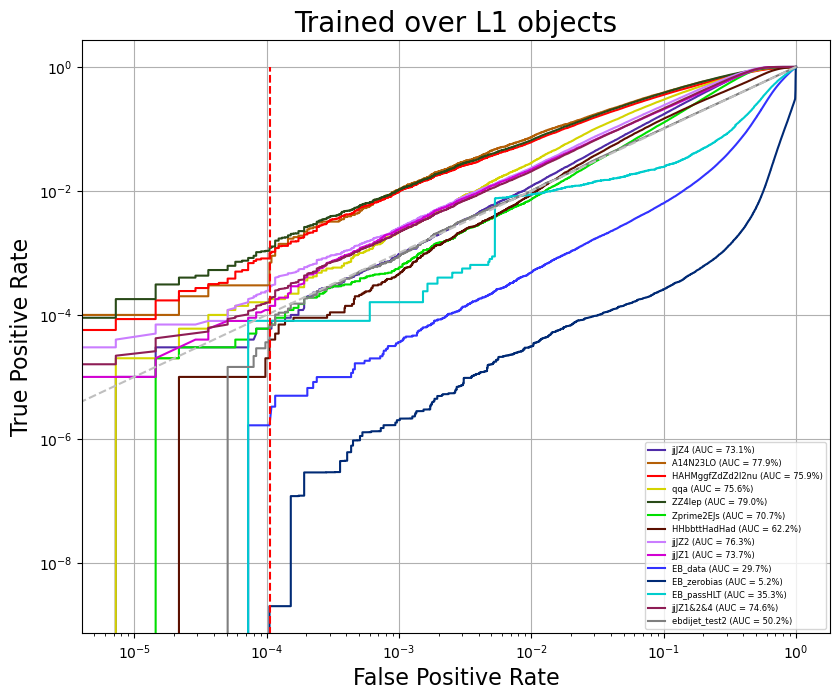

Normalized by the left bar:
[1.         1.00104167 1.00033332 1.00154491 1.00016078 1.
 1.00001836 1.02521008 1.06018519 1.         1.         1.
 1.00081352 1.00055106]


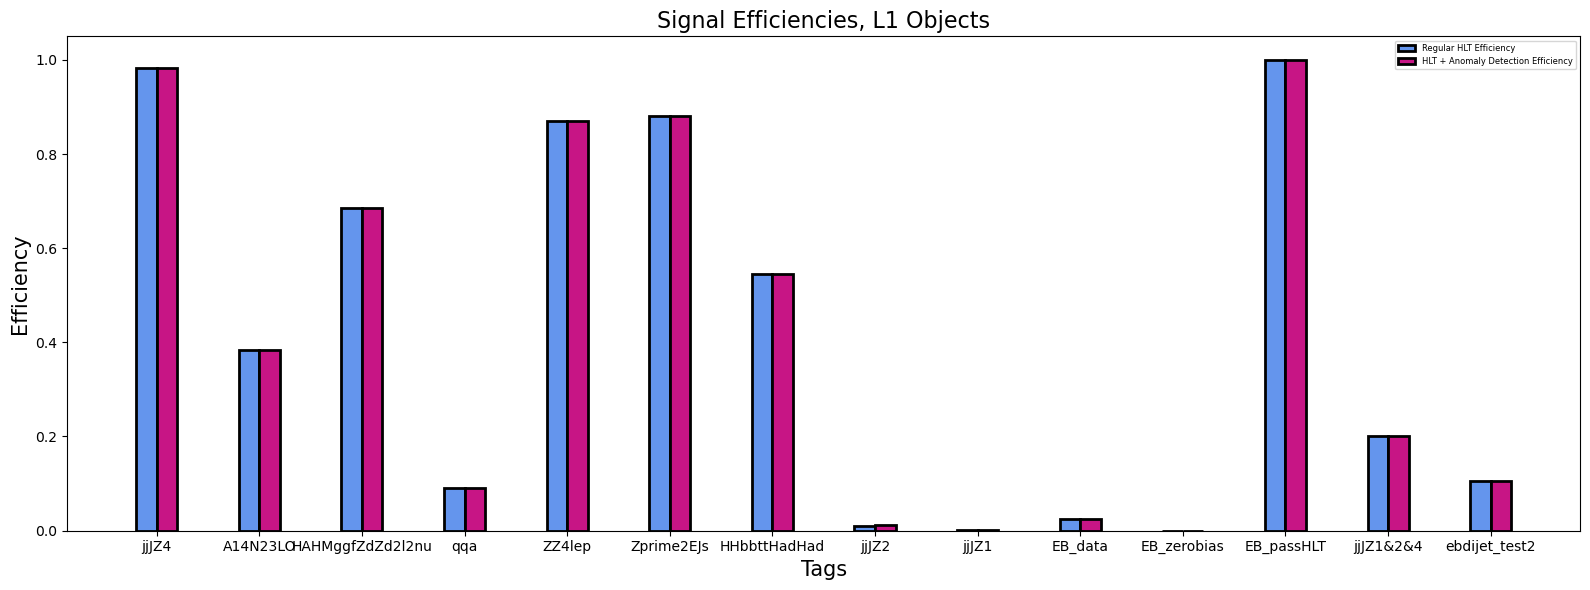

Normalized by the left bar:
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


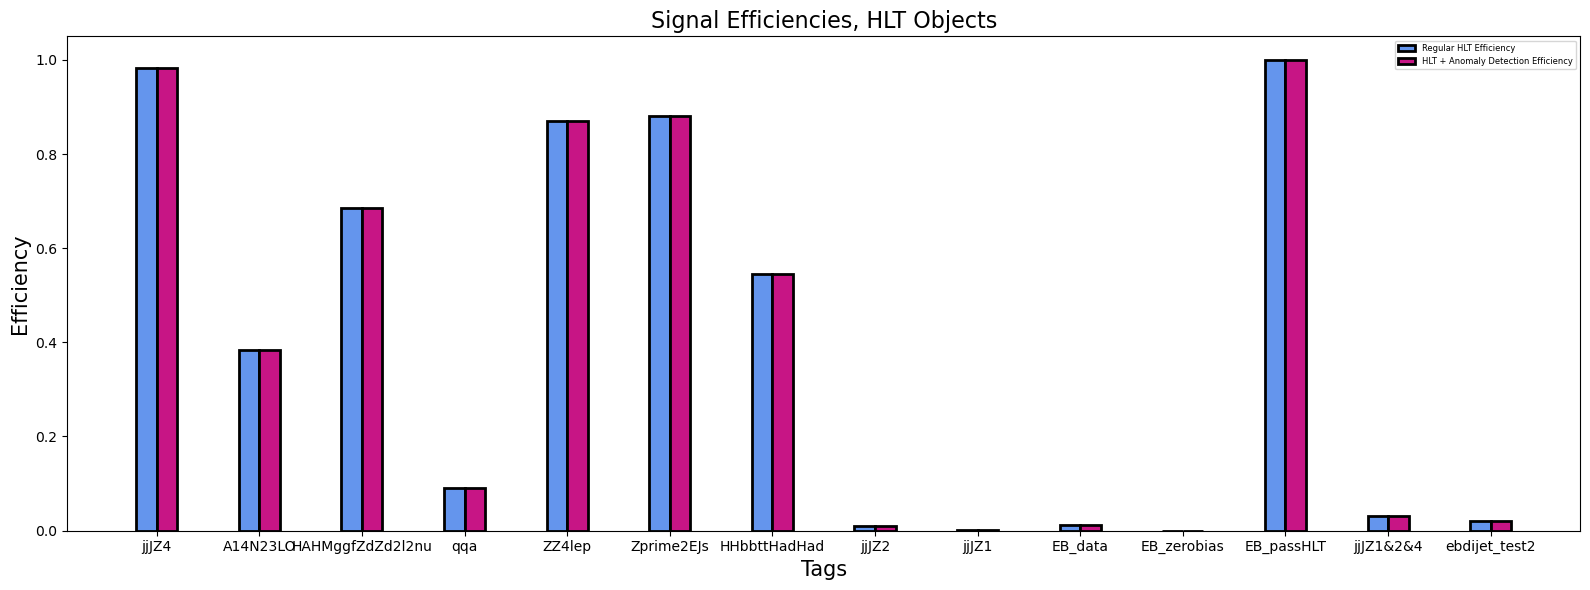

-----
jjJZ4:
HLT overlap: 1.0
inverse overlap: 1.0
Weighted percentage of events that passed some HLT trigger: 0.98223
Weighted percentage of events that we tagged as anomalous: 0.00018
Raw number of events that we tagged as anomalous: 18
Raw number of events that passed some HLT trigger: 98223
Raw number of events that we tagged as anomalous and passed some HLT trigger: 18
-----
A14N23LO:
HLT overlap: 0.75
inverse overlap: 1.00078125
Weighted percentage of events that passed some HLT trigger: 0.384
Weighted percentage of events that we tagged as anomalous: 0.0012
Raw number of events that we tagged as anomalous: 12
Raw number of events that passed some HLT trigger: 3840
Raw number of events that we tagged as anomalous and passed some HLT trigger: 9
-----
HAHMggfZdZd2l2nu:
HLT overlap: 0.9626168224299065
inverse overlap: 1.0009999583350693
Weighted percentage of events that passed some HLT trigger: 0.6857428571428571
Weighted percentage of events that we tagged as anomalous: 0.01834285

/tmp/ipykernel_199/3082989878.py:155: RuntimeWarning: invalid value encountered in scalar divide
  HLT_overlap = np.sum(datasets[tag]['HLTweights'] * (HLT_anomaly_idxs & datasets[tag]['passHLT'])) / np.sum(datasets[tag]['HLTweights'] * HLT_anomaly_idxs)


Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.01e+02Hz


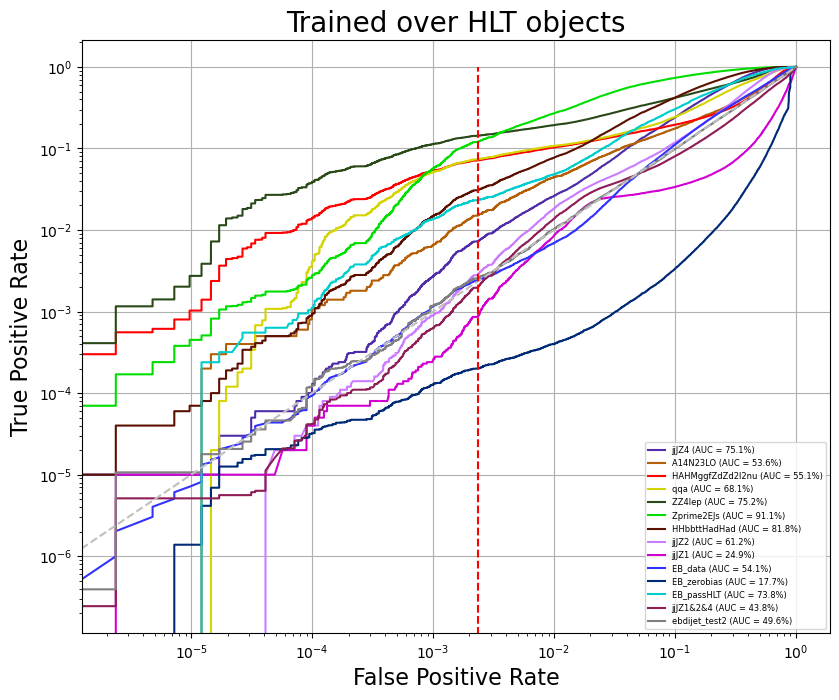

Background rate = 2.02e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2.02e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz
Background rate = 2.01e+02Hz
Background rate = 2.02e+02Hz
Background rate = 2.07e+02Hz
Background rate = 2e+02Hz
Background rate = 2e+02Hz


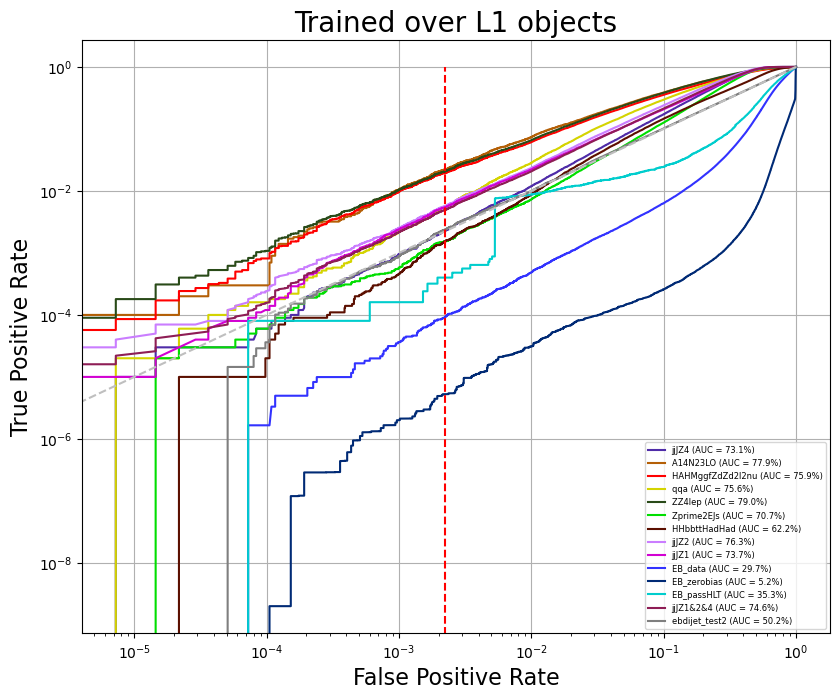

Normalized by the left bar:
[ 1.00004072  1.03619792  1.00743719  1.05627897  1.00304342  1.00010217
  1.00159768  1.52287582  3.49537037  1.0034132  10.13885536  1.
  1.02184589  1.0203203 ]


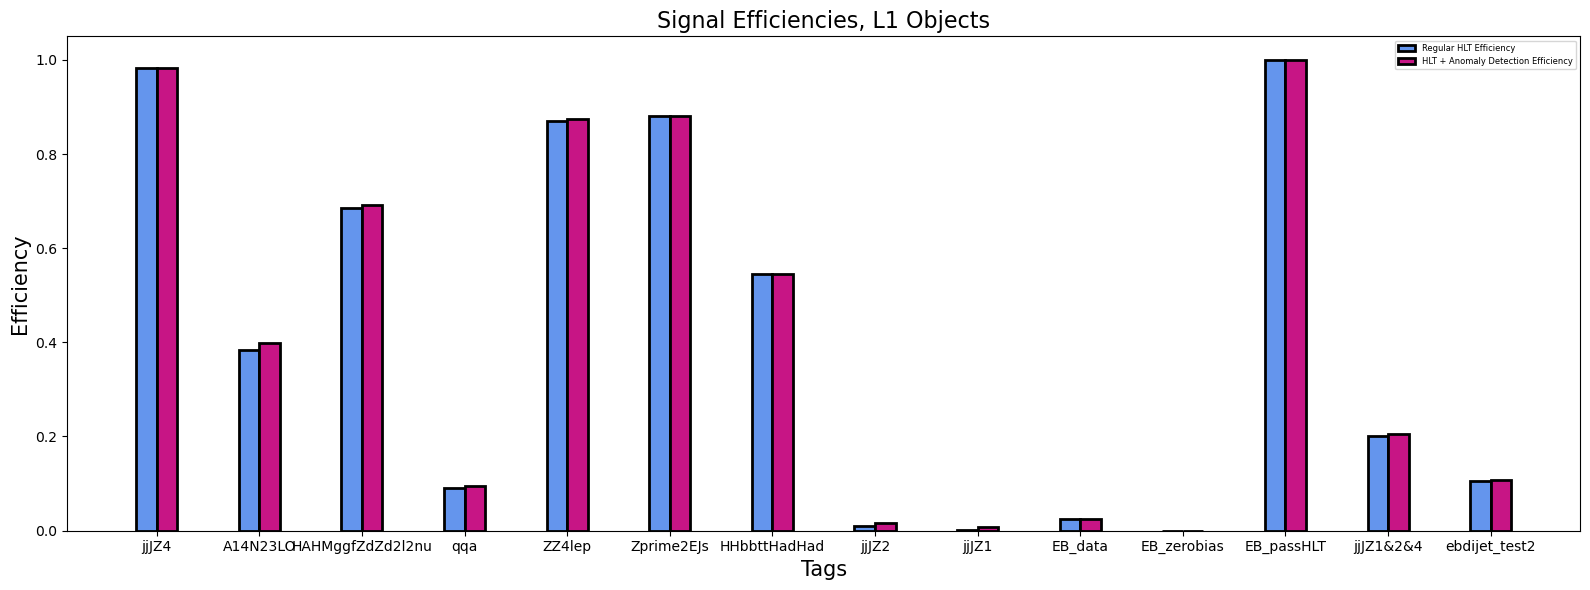

Normalized by the left bar:
[1.00001018 1.01041667 1.00220824 1.01302141 1.00118292 1.00003406
 1.00036728 1.15406162 1.66203704 1.00081552 3.30279301 1.
 1.04970031 1.02886021]


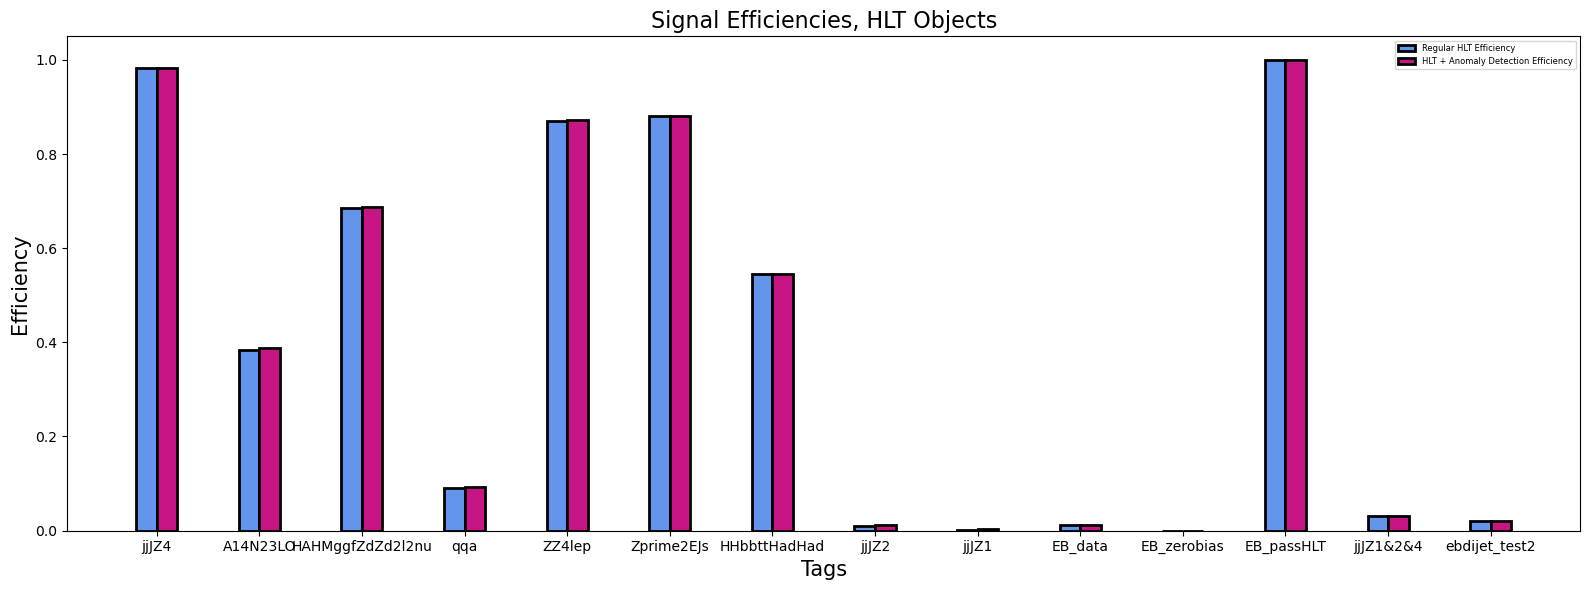

-----
jjJZ4:
HLT overlap: 0.9917920656634747
inverse overlap: 1.000061085489142
Weighted percentage of events that passed some HLT trigger: 0.98223
Weighted percentage of events that we tagged as anomalous: 0.00731
Raw number of events that we tagged as anomalous: 731
Raw number of events that passed some HLT trigger: 98223
Raw number of events that we tagged as anomalous and passed some HLT trigger: 725
-----
A14N23LO:
HLT overlap: 0.7105263157894737
inverse overlap: 1.0114583333333333
Weighted percentage of events that passed some HLT trigger: 0.384
Weighted percentage of events that we tagged as anomalous: 0.0152
Raw number of events that we tagged as anomalous: 152
Raw number of events that passed some HLT trigger: 3840
Raw number of events that we tagged as anomalous and passed some HLT trigger: 108
-----
HAHMggfZdZd2l2nu:
HLT overlap: 0.929828068772491
inverse overlap: 1.007312195325195
Weighted percentage of events that passed some HLT trigger: 0.6857428571428571
Weighted percen

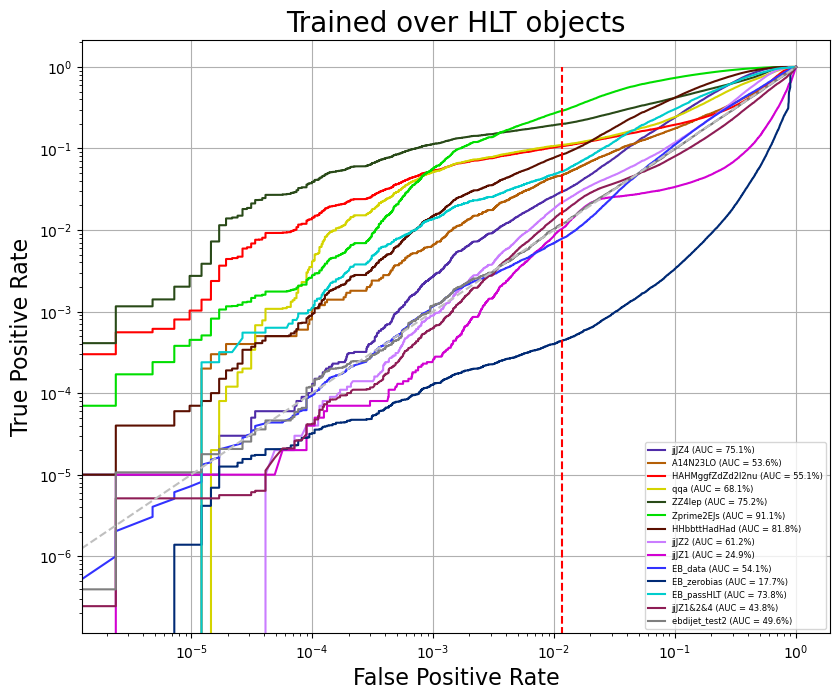

Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz
Background rate = 1e+03Hz


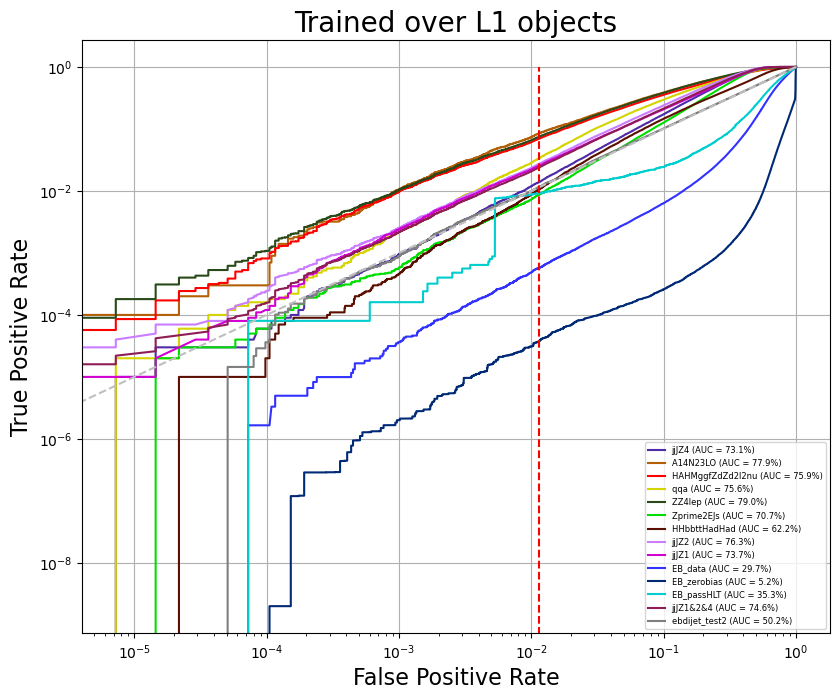

Normalized by the left bar:
[ 1.0004276   1.14244792  1.02799883  1.33325977  1.01170282  1.00061302
  1.01043082  3.5070028  12.71759259  1.02154999 65.43174153  1.
  1.10387214  1.09705528]


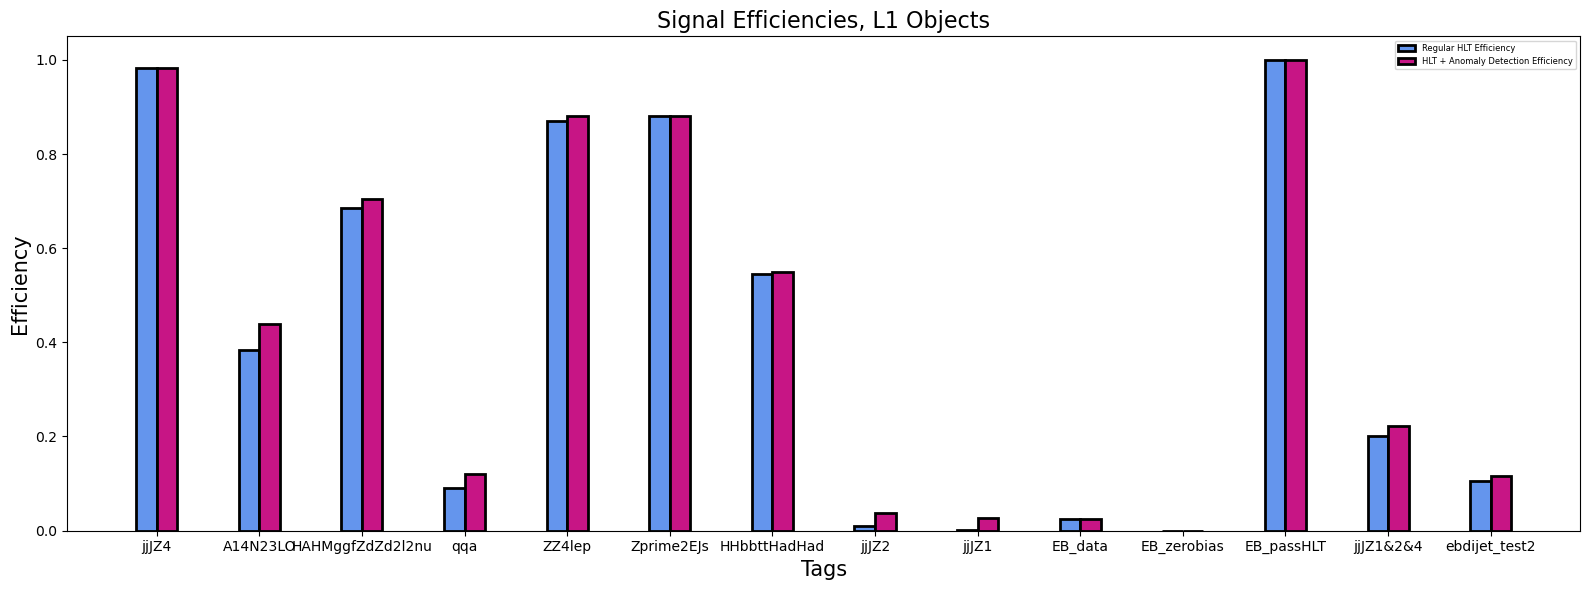

Normalized by the left bar:
[  1.00080429   1.22447917   1.04924795   1.67556831   1.01891516
   1.00164608   1.02302861   5.76937442  22.53240741   1.11141453
 132.44313977   1.           2.57513936   2.0445669 ]


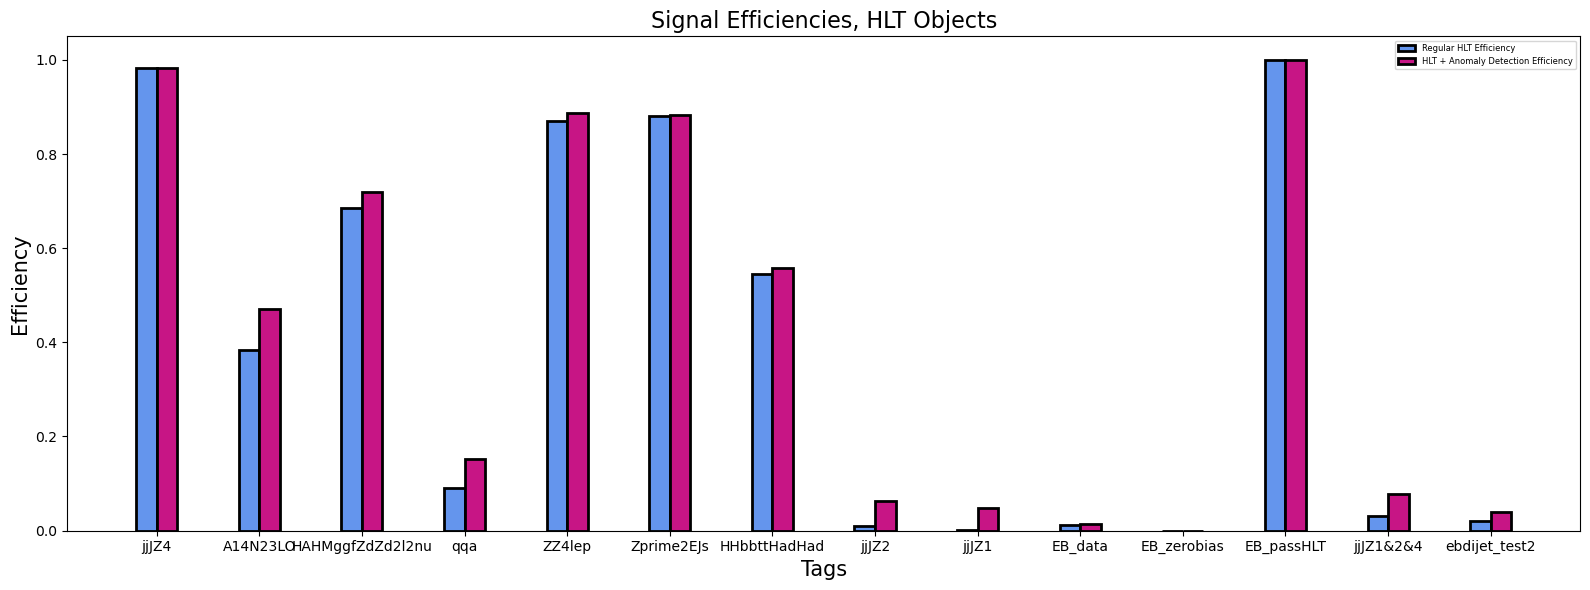

-----
jjJZ4:
HLT overlap: 0.9898408398239079
inverse overlap: 1.0003054274457104
Weighted percentage of events that passed some HLT trigger: 0.98223
Weighted percentage of events that we tagged as anomalous: 0.02953
Raw number of events that we tagged as anomalous: 2953
Raw number of events that passed some HLT trigger: 98223
Raw number of events that we tagged as anomalous and passed some HLT trigger: 2923
-----
A14N23LO:
HLT overlap: 0.6716417910447762
inverse overlap: 1.0401041666666666
Weighted percentage of events that passed some HLT trigger: 0.384
Weighted percentage of events that we tagged as anomalous: 0.0469
Raw number of events that we tagged as anomalous: 469
Raw number of events that passed some HLT trigger: 3840
Raw number of events that we tagged as anomalous and passed some HLT trigger: 315
-----
HAHMggfZdZd2l2nu:
HLT overlap: 0.9057640750670242
inverse overlap: 1.0146452231157035
Weighted percentage of events that passed some HLT trigger: 0.6857428571428571
Weighted p

In [178]:
for target_rate in [10, 200, 1000]:
    print(f'TARGET (PURE) RATE::::: {target_rate}')
    HLT_results = ROC_curveHLT(datasets,target_rate=target_rate)
    L1_results = ROC_curveL1(datasets, target_rate=target_rate)

    # L1 Signal Efficiencies

    tags = []
    l1_efficiencies = []
    combined_efficiencies = []
    
    skip_tags = ['ebdijet_train', 'ebdijet_test1']
    for tag, dict in datasets.items():
        if tag in skip_tags: 
            continue
    
        # Extract HLT and L1 results from the respective dictionaries
        hlt_result = HLT_results.get(tag)
        l1_result = L1_results.get(tag)
        
        if hlt_result and l1_result:
            # Extract TPR for regular HLT efficiency
            #HLT_TPR = hlt_result['TPR']
            L1_TPR = np.sum(dict['passHLT'] * dict['L1weights']) / np.sum(dict['L1weights'])
            
            # Calculate the combined efficiency (HLT + Anomaly Detection)
            L1_anomaly_idxs = datasets[tag]['L1_AD_scores'] > L1_results[tag]['threshold']
            L1_or_anom_TPR = np.sum((datasets[tag]['passHLT'] | L1_anomaly_idxs) * datasets[tag]['L1weights']) / np.sum(datasets[tag]['L1weights'])
            
            tags.append(tag)
            l1_efficiencies.append(L1_TPR)
            combined_efficiencies.append(L1_or_anom_TPR)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot regular HLT efficiency
    bar_width = 0.2
    index = np.arange(len(tags))
    bar1 = ax.bar(index, l1_efficiencies, bar_width, label='Regular HLT Efficiency', color='cornflowerblue', edgecolor='k', linewidth=2)
    
    # Plot combined efficiency (HLT + Anomaly Detection)
    bar2 = ax.bar(index + bar_width, combined_efficiencies, bar_width, label='HLT + Anomaly Detection Efficiency', color='mediumvioletred', edgecolor='k', linewidth=2)
    print(f'Normalized by the left bar:\n{np.array(combined_efficiencies) / np.array(l1_efficiencies)}')
    # Add labels and title
    ax.set_xlabel('Tags', fontsize=15)
    ax.set_ylabel('Efficiency', fontsize=15)
    ax.set_title('Signal Efficiencies, L1 Objects', fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(tags)
    #ax.set_yscale('log')
    ax.legend(fontsize=6)
    
    plt.tight_layout()
    plt.show()



    # Signal Efficiencies

    tags = []
    hlt_efficiencies = []
    combined_efficiencies = []
    
    skip_tags = ['ebdijet_train', 'ebdijet_test1']
    for tag, dict in datasets.items():
        if tag in skip_tags: 
            continue
    
        # Extract HLT and L1 results from the respective dictionaries
        hlt_result = HLT_results.get(tag)
        l1_result = L1_results.get(tag)
        
        if hlt_result and l1_result:
            # Extract TPR for regular HLT efficiency
            #HLT_TPR = hlt_result['TPR']
            HLT_TPR = np.sum(dict['passHLT'] * dict['HLTweights']) / np.sum(dict['HLTweights'])
            
            # Calculate the combined efficiency (HLT + Anomaly Detection)
            HLT_anomaly_idxs = datasets[tag]['L1_AD_scores'] > HLT_results[tag]['threshold']
            HLT_or_anom_TPR = np.sum((datasets[tag]['passHLT'] | HLT_anomaly_idxs) * datasets[tag]['HLTweights']) / np.sum(datasets[tag]['HLTweights'])
            
            tags.append(tag)
            hlt_efficiencies.append(HLT_TPR)
            combined_efficiencies.append(HLT_or_anom_TPR)
    
    # Create bar plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot regular HLT efficiency
    bar_width = 0.2
    index = np.arange(len(tags))
    bar1 = ax.bar(index, hlt_efficiencies, bar_width, label='Regular HLT Efficiency', color='cornflowerblue', edgecolor='k', linewidth=2)
    
    # Plot combined efficiency (HLT + Anomaly Detection)
    bar2 = ax.bar(index + bar_width, combined_efficiencies, bar_width, label='HLT + Anomaly Detection Efficiency', color='mediumvioletred', edgecolor='k', linewidth=2)
    print(f'Normalized by the left bar:\n{np.array(combined_efficiencies) / np.array(hlt_efficiencies)}')
    # Add labels and title
    ax.set_xlabel('Tags', fontsize=15)
    ax.set_ylabel('Efficiency', fontsize=15)
    ax.set_title('Signal Efficiencies, HLT Objects', fontsize=16)
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(tags)
    #ax.set_yscale('log')
    ax.legend(fontsize=6)
    
    plt.tight_layout()
    plt.show()
    
    # HLT overlaps
    skip_tags = ['ebdijet_train', 'ebdijet_test1']
    for tag in datasets.keys():
        if tag in skip_tags:
            continue
    
        # Extract relevant information from the results dictionaries
        hlt_result = HLT_results.get(tag)
        
        if hlt_result:
            HLT_threshold = hlt_result['threshold']
            
            # Calculate HLT anomaly indices based on the threshold
            HLT_anomaly_idxs = datasets[tag]['HLT_AD_scores'] > HLT_threshold
    
            # Calculate overlaps
            HLT_overlap = np.sum(datasets[tag]['HLTweights'] * (HLT_anomaly_idxs & datasets[tag]['passHLT'])) / np.sum(datasets[tag]['HLTweights'] * HLT_anomaly_idxs)
            inverse_overlap = np.sum(datasets[tag]['HLTweights'] * (HLT_anomaly_idxs | datasets[tag]['passHLT'])) / np.sum(datasets[tag]['HLTweights'] * datasets[tag]['passHLT'])
    
            # Print the results
            print(f'-----\n{tag}:')
            print(f'HLT overlap: {HLT_overlap}')
            print(f'inverse overlap: {inverse_overlap}')
            print(f"Weighted percentage of events that passed some HLT trigger: {np.sum(datasets[tag]['passHLT']) / len(datasets[tag]['passHLT'])}")
            print(f"Weighted percentage of events that we tagged as anomalous: {np.sum(HLT_anomaly_idxs) / len(HLT_anomaly_idxs)}")
            print(f'Raw number of events that we tagged as anomalous: {np.sum(HLT_anomaly_idxs)}')
            print(f"Raw number of events that passed some HLT trigger: {np.sum(datasets[tag]['passHLT'])}")
            print(f"Raw number of events that we tagged as anomalous and passed some HLT trigger: {np.sum(HLT_anomaly_idxs * datasets[tag]['passHLT'])}")

    # HLT overlaps
    skip_tags = ['ebdijet_train', 'ebdijet_test1']
    for tag in datasets.keys():
        if tag in skip_tags:
            continue
    
        # Extract relevant information from the results dictionaries
        hlt_result = L1_results.get(tag)
        
        if hlt_result:
            HLT_threshold = hlt_result['threshold']
            
            # Calculate HLT anomaly indices based on the threshold
            HLT_anomaly_idxs = datasets[tag]['L1_AD_scores'] > HLT_threshold
    
            # Calculate overlaps
            HLT_overlap = np.sum(datasets[tag]['HLTweights'] * (HLT_anomaly_idxs & datasets[tag]['passHLT'])) / np.sum(datasets[tag]['HLTweights'] * HLT_anomaly_idxs)
            inverse_overlap = np.sum(datasets[tag]['HLTweights'] * (HLT_anomaly_idxs | datasets[tag]['passHLT'])) / np.sum(datasets[tag]['HLTweights'] * datasets[tag]['passHLT'])
    
            # Print the results
            print(f'-----\n{tag}:')
            print(f'HLT overlap: {HLT_overlap}')
            print(f'inverse overlap: {inverse_overlap}')
            print(f"Weighted percentage of events that passed some HLT trigger: {np.sum(datasets[tag]['passHLT']) / len(datasets[tag]['passHLT'])}")
            print(f"Weighted percentage of events that we tagged as anomalous: {np.sum(HLT_anomaly_idxs) / len(HLT_anomaly_idxs)}")
            print(f'Raw number of events that we tagged as anomalous: {np.sum(HLT_anomaly_idxs)}')
            print(f"Raw number of events that passed some HLT trigger: {np.sum(datasets[tag]['passHLT'])}")
            print(f"Raw number of events that we tagged as anomalous and passed some HLT trigger: {np.sum(HLT_anomaly_idxs * datasets[tag]['passHLT'])}")


In [179]:
#HLT
efficiencies = {}

bins = np.zeros(20)
bins[0] = 50
for i in range(1,20):
    bins[i] = 100 + bins[i-1]
    
for tag, dict in datasets.items():
    efficiency = np.zeros(20)
    if tag == 'ebdijet_test1': continue
    if tag == 'ebdijet_train': continue
    threshold = hlt_result['threshold']
    for i in range(0,20):
        mask = np.zeros((len(datasets[tag]['HLT_AD_scores'])),dtype='bool')
        l = i * 100
        r = i * 100 + 100
        for n in range(len(datasets[tag]['HLT_AD_scores'])):
            if (HLT_max_pt_vals[tag][n] > l) and (HLT_max_pt_vals[tag][n] < r):
                mask[n] = True
        data1 = datasets[tag]['HLT_AD_scores'][mask]
        weight = datasets[tag]['HLTweights'][mask]
        sumA = 0
        sumB = 0
        for j in range(len(data1)):
            if data1[j] > threshold:
                sumA += weight[j]
            sumB += weight[j]
        if sumB != 0:
            efficiency[i] = sumA/sumB
    efficiencies[tag] = efficiency
    

In [180]:
#HLT
efficiencies2 = {}

bins = np.zeros(20)
bins[0] = 50
for i in range(1,20):
    bins[i] = 100 + bins[i-1]
    
for tag, dict in datasets.items():
    efficiency = np.zeros(20)
    if tag == 'ebdijet_test1': continue
    if tag == 'ebdijet_train': continue
    threshold = hlt_result['threshold']
    for i in range(0,20):
        mask = np.zeros((len(datasets[tag]['HLT_AD_scores'])),dtype='bool')
        l = i * 100
        r = i * 100 + 100
        for n in range(len(datasets[tag]['HLT_AD_scores'])):
            if (HLT_max_pt_vals[tag][n] > l) and (HLT_max_pt_vals[tag][n] < r) and (HLT_jet_mults[tag][n]  > 5):
                mask[n] = True
        data1 = datasets[tag]['HLT_AD_scores'][mask]
        weight = datasets[tag]['HLTweights'][mask]
        sumA = 0
        sumB = 0
        for j in range(len(data1)):
            if data1[j] > threshold:
                sumA += weight[j]
            sumB += weight[j]
        if sumB != 0:
            efficiency[i] = sumA/sumB
    efficiencies2[tag] = efficiency
    

In [181]:
#HLT
efficiencies3 = {}

bins = np.zeros(20)
bins[0] = 50
for i in range(1,20):
    bins[i] = 100 + bins[i-1]
    
for tag, dict in datasets.items():
    efficiency = np.zeros(20)
    if tag == 'ebdijet_test1': continue
    if tag == 'ebdijet_train': continue
    threshold = hlt_result['threshold']
    for i in range(0,20):
        mask = np.zeros((len(datasets[tag]['HLT_AD_scores'])),dtype='bool')
        l = i * 100
        r = i * 100 + 100
        for n in range(len(datasets[tag]['HLT_AD_scores'])):
            if (HLT_max_pt_vals[tag][n] > l) and (HLT_max_pt_vals[tag][n] < r) and (HLT_jet_mults[tag][n] > 1) and (HLT_electron_mults[tag][n] > 1) and (HLT_muon_mults[tag][n] > 1) and (HLT_photon_mults[tag][n] > 1):
                mask[n] = True
        data1 = datasets[tag]['HLT_AD_scores'][mask]
        weight = datasets[tag]['HLTweights'][mask]
        sumA = 0
        sumB = 0
        for j in range(len(data1)):
            if data1[j] > threshold:
                sumA += weight[j]
            sumB += weight[j]
        if sumB != 0:
            efficiency[i] = sumA/sumB
    efficiencies3[tag] = efficiency
    

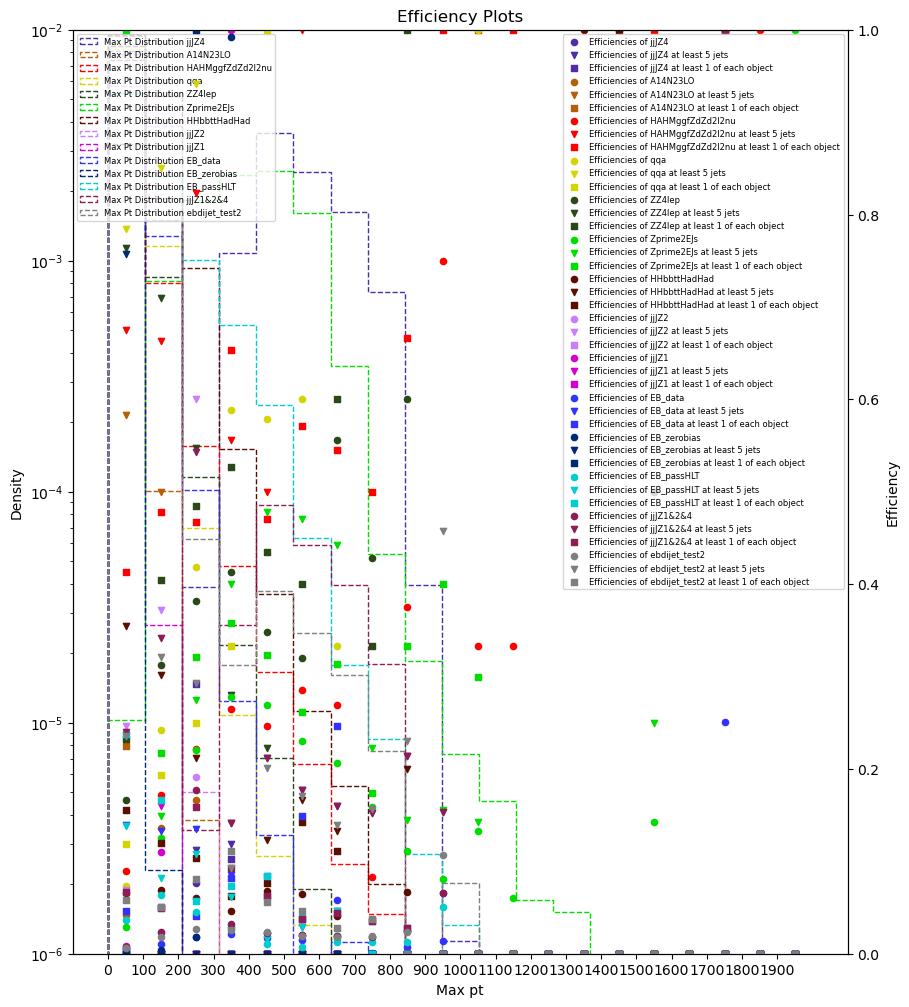

In [182]:
fig, ax1 = plt.subplots(figsize=(10, 12))
    # Plot on the left y-axis (logarithmic scale)
ax1.set_yscale('log')
ax1.set_xlabel('Max pt')
ax1.set_ylabel('Density')
ax1.set_ylim(1e-6, 1e-2)
    # Create a second y-axis for efficiency
ax2 = ax1.twinx()
ax2.set_ylabel('Efficiency')
ax2.set_ylim(0, 1)

i = 0
for tag, dict in datasets.items():
    if tag == 'ebdijet_test1': continue
    if tag == 'ebdijet_train': continue
    ax1.hist(HLT_max_pt_vals[tag], bins=np.linspace(0,2000, 20), label=f'Max Pt Distribution {tag}', histtype='step', ls='--', density=True, fill=False, linewidth=1, weights=datasets[tag]['HLTweights'],color=new_color_cycle[i])
    ax2.scatter(bins,efficiencies[tag],s=20,c=new_color_cycle[i],marker="o",label=f'Efficiencies of {tag}')
    ax2.scatter(bins,efficiencies2[tag],s=20,c=new_color_cycle[i],marker="v",label=f'Efficiencies of {tag} at least 5 jets')
    ax2.scatter(bins,efficiencies3[tag],s=20,c=new_color_cycle[i],marker="s",label=f'Efficiencies of {tag} at least 1 of each object')
    i += 1

plt.xticks(np.arange(0, 2000,100))
plt.title(f'Efficiency Plots', loc='center')
ax1.legend(loc='upper left', fontsize=6)
ax2.legend(loc='upper right', fontsize=6)
plt.show()

In [183]:
#L1
efficiencies = {}

bins = np.zeros(20)
bins[0] = 50
for i in range(1,20):
    bins[i] = 100 + bins[i-1]
    
for tag, dict in datasets.items():
    efficiency = np.zeros(20)
    if tag == 'ebdijet_test1': continue
    if tag == 'ebdijet_train': continue
    threshold = l1_result['threshold']
    for i in range(0,20):
        mask = np.zeros((len(datasets[tag]['L1_AD_scores'])),dtype='bool')
        l = i * 100
        r = i * 100 + 100
        for n in range(len(datasets[tag]['L1_AD_scores'])):
            if (L1_max_pt_vals[tag][n] > l) and (L1_max_pt_vals[tag][n] < r):
                mask[n] = True
        data1 = datasets[tag]['L1_AD_scores'][mask]
        weight = datasets[tag]['L1weights'][mask]
        sumA = 0
        sumB = 0
        for j in range(len(data1)):
            if data1[j] > threshold:
                sumA += weight[j]
            sumB += weight[j]
        if sumB != 0:
            efficiency[i] = sumA/sumB
    efficiencies[tag] = efficiency
    

In [184]:

efficiencies2 = {}

bins = np.zeros(20)
bins[0] = 50
for i in range(1,20):
    bins[i] = 100 + bins[i-1]
    
for tag, dict in datasets.items():
    efficiency = np.zeros(20)
    if tag == 'ebdijet_test1': continue
    if tag == 'ebdijet_train': continue
    threshold = l1_result['threshold']
    for i in range(0,20):
        mask = np.zeros((len(datasets[tag]['L1_AD_scores'])),dtype='bool')
        l = i * 100
        r = i * 100 + 100
        for n in range(len(datasets[tag]['L1_AD_scores'])):
            if (L1_max_pt_vals[tag][n] > l) and (L1_max_pt_vals[tag][n] < r) and (L1_jet_mults[tag][n]  > 5):
                mask[n] = True
        data1 = datasets[tag]['L1_AD_scores'][mask]
        weight = datasets[tag]['L1weights'][mask]
        sumA = 0
        sumB = 0
        for j in range(len(data1)):
            if data1[j] > threshold:
                sumA += weight[j]
            sumB += weight[j]
        if sumB != 0:
            efficiency[i] = sumA/sumB
    efficiencies2[tag] = efficiency
    

In [185]:
efficiencies3 = {}

bins = np.zeros(20)
bins[0] = 50
for i in range(1,20):
    bins[i] = 100 + bins[i-1]
    
for tag, dict in datasets.items():
    efficiency = np.zeros(20)
    if tag == 'ebdijet_test1': continue
    if tag == 'ebdijet_train': continue
    threshold = l1_result['threshold']
    for i in range(0,20):
        mask = np.zeros((len(datasets[tag]['L1_AD_scores'])),dtype='bool')
        l = i * 100
        r = i * 100 + 100
        for n in range(len(datasets[tag]['L1_AD_scores'])):
            if (L1_max_pt_vals[tag][n] > l) and (L1_max_pt_vals[tag][n] < r) and (L1_jet_mults[tag][n] > 1) and (L1_electron_mults[tag][n] > 1) and (L1_muon_mults[tag][n] > 1) and (L1_photon_mults[tag][n] > 1):
                mask[n] = True
        data1 = datasets[tag]['L1_AD_scores'][mask]
        weight = datasets[tag]['L1weights'][mask]
        sumA = 0
        sumB = 0
        for j in range(len(data1)):
            if data1[j] > threshold:
                sumA += weight[j]
            sumB += weight[j]
        if sumB != 0:
            efficiency[i] = sumA/sumB
    efficiencies3[tag] = efficiency
    

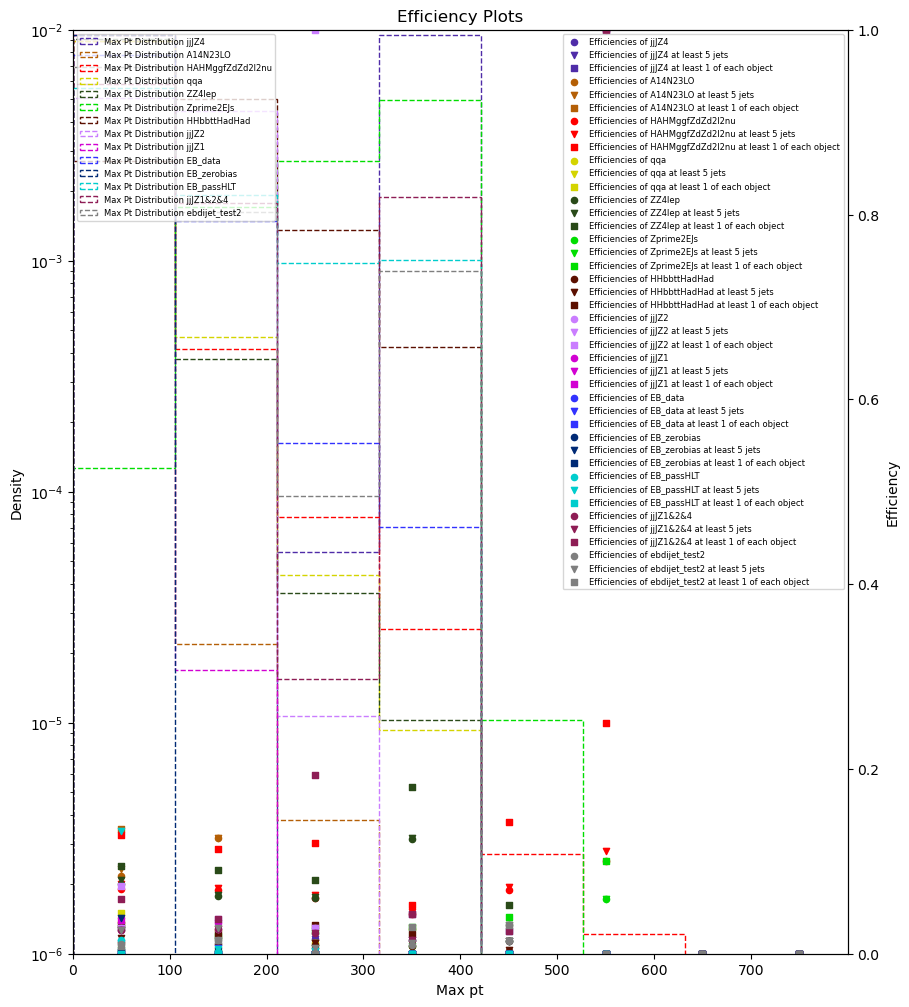

In [186]:
fig, ax1 = plt.subplots(figsize=(10, 12))
    # Plot on the left y-axis (logarithmic scale)
ax1.set_yscale('log')
ax1.set_xlabel('Max pt')
ax1.set_ylabel('Density')
ax1.set_ylim(1e-6, 1e-2)
    # Create a second y-axis for efficiency
ax2 = ax1.twinx()
ax2.set_ylabel('Efficiency')
ax2.set_ylim(0, 1)

i = 0
for tag, dict in datasets.items():
    if tag == 'ebdijet_test1': continue
    if tag == 'ebdijet_train': continue
    ax1.hist(L1_max_pt_vals[tag], bins=np.linspace(0,2000, 20), label=f'Max Pt Distribution {tag}', histtype='step', ls='--', density=True, fill=False, linewidth=1, weights=datasets[tag]['L1weights'],color=new_color_cycle[i])
    ax2.scatter(bins,efficiencies[tag],s=20,c=new_color_cycle[i],marker="o",label=f'Efficiencies of {tag}')
    ax2.scatter(bins,efficiencies2[tag],s=20,c=new_color_cycle[i],marker="v",label=f'Efficiencies of {tag} at least 5 jets')
    ax2.scatter(bins,efficiencies3[tag],s=20,c=new_color_cycle[i],marker="s",label=f'Efficiencies of {tag} at least 1 of each object')
    i += 1
plt.xlim(0, 800)
plt.xticks(np.arange(0, 800,100))
plt.title(f'Efficiency Plots', loc='center')
ax1.legend(loc='upper left', fontsize=6)
ax2.legend(loc='upper right', fontsize=6)
plt.show()

In [187]:
import ROOT

ModuleNotFoundError: No module named 'ROOT'

In [ ]:
for tag, dict in datasets.items():
    if tag == 'ebdijet_train': continue
    title = "HLT" + tag + "max pt v ad score  "
    histogram = ROOT.TH2F(title, title, 50, 0, 1600, 50, 0, 5)
    histogram.SetXTitle("Max pt")  
    histogram.SetYTitle("AD Score")
    for x, y in zip(HLT_max_pt_vals[tag], datasets[tag]['HLT_AD_scores']):
        histogram.Fill(x, y)
    norm = 1
    binsX = 50  
    binsY = 50  
    for i in range(1, binsX + 1):
        num_events = 0.0
        for j in range(1, binsY + 1):
            bincont = histogram.GetBinContent(i, j)
            num_events += bincont
        if num_events > 0: 
            for j in range(1, binsY + 1):
                bincont = histogram.GetBinContent(i, j)
                fact = norm / num_events
                value = bincont * fact
                histogram.SetBinContent(i, j, value)
    ROOT.gStyle.SetStatX(0.9)  
    ROOT.gStyle.SetStatY(0.9)   
    ROOT.gStyle.SetStatW(0.1) 
    ROOT.gStyle.SetStatH(0.1)
        
    canvas = ROOT.TCanvas(title,title, 450, 300)
    canvas.SetLogz()  
    histogram.Draw("COLZ") 
    threshold = hlt_result['threshold']

    redline = ROOT.TLine(0,threshold,1600,threshold)
    redline.SetLineWidth(2)
    redline.SetLineColor(2)
    redline.Draw()
        
    canvas.Update()
    canvas.Draw()
    output_path = os.path.join('/home/jovyan/Root/HLT', f"{title}_plot.png")
    canvas.SaveAs(output_path)


In [ ]:
for tag, dict in datasets.items():
    if tag == 'ebdijet_train': continue
    title = "L1" + tag + "max pt v ad score  "
    histogram = ROOT.TH2F(title, title, 50, 0, 1600, 50, 0, 5)
    histogram.SetXTitle("Max pt")  
    histogram.SetYTitle("AD Score")
    for x, y in zip(HLT_max_pt_vals[tag], datasets[tag]['L1_AD_scores']):
        histogram.Fill(x, y)
    norm = 1
    binsX = 50  
    binsY = 50  
    for i in range(1, binsX + 1):
        num_events = 0.0
        for j in range(1, binsY + 1):
            bincont = histogram.GetBinContent(i, j)
            num_events += bincont
        if num_events > 0: 
            for j in range(1, binsY + 1):
                bincont = histogram.GetBinContent(i, j)
                fact = norm / num_events
                value = bincont * fact
                histogram.SetBinContent(i, j, value)
    ROOT.gStyle.SetStatX(0.9)  
    ROOT.gStyle.SetStatY(0.9)   
    ROOT.gStyle.SetStatW(0.1) 
    ROOT.gStyle.SetStatH(0.1)
        
    canvas = ROOT.TCanvas(title,title, 450, 300)
    canvas.SetLogz()  
    histogram.Draw("COLZ") 
    threshold = l1_result['threshold']

    redline = ROOT.TLine(0,threshold,1600,threshold)
    redline.SetLineWidth(2)
    redline.SetLineColor(2)
    redline.Draw()
        
    canvas.Update()
    canvas.Draw()
    output_path = os.path.join('/home/jovyan/RootPlots/Final5', f"{title}_plot.png")
    canvas.SaveAs(output_path)


In [ ]:
for tag, dict in datasets.items():
    if tag == 'ebdijet_train': continue
    title = "HLT" + tag + "jet mult v ad score  "
    histogram = ROOT.TH2F(title, title, 50, 0, 10, 50, 0, 5)
    histogram.SetXTitle("Jet Multiplicity")  
    histogram.SetYTitle("AD Score")
    for x, y in zip(HLT_jet_mults[tag], datasets[tag]['HLT_AD_scores']):
        histogram.Fill(x, y)
    norm = 1
    binsX = 50  
    binsY = 50  
    for i in range(1, binsX + 1):
        num_events = 0.0
        for j in range(1, binsY + 1):
            bincont = histogram.GetBinContent(i, j)
            num_events += bincont
        if num_events > 0: 
            for j in range(1, binsY + 1):
                bincont = histogram.GetBinContent(i, j)
                fact = norm / num_events
                value = bincont * fact
                histogram.SetBinContent(i, j, value)
    ROOT.gStyle.SetStatX(0.9)  
    ROOT.gStyle.SetStatY(0.9)   
    ROOT.gStyle.SetStatW(0.1) 
    ROOT.gStyle.SetStatH(0.1)
        
    canvas = ROOT.TCanvas(title,title, 450, 300)
    canvas.SetLogz()  
    histogram.Draw("COLZ") 
    threshold = hlt_result['threshold']

    redline = ROOT.TLine(0,threshold,10,threshold)
    redline.SetLineWidth(2)
    redline.SetLineColor(2)
    redline.Draw()
        
    canvas.Update()
    canvas.Draw()
    output_path = os.path.join('/home/jovyan/RootPlots/Final5', f"{title}_plot.png")
    canvas.SaveAs(output_path)


In [ ]:
for tag, dict in datasets.items():
    if tag == 'ebdijet_train': continue
    title = "L1" + tag + "jet mult v ad score "
    histogram = ROOT.TH2F(title, title, 50, 0, 10, 50, 0, 5)
    histogram.SetXTitle("Jet Multiplicity")  
    histogram.SetYTitle("AD Score")
    for x, y in zip(L1_jet_mults[tag], datasets[tag]['L1_AD_scores']):
        histogram.Fill(x, y)
    norm = 1
    binsX = 50  
    binsY = 50  
    for i in range(1, binsX + 1):
        num_events = 0.0
        for j in range(1, binsY + 1):
            bincont = histogram.GetBinContent(i, j)
            num_events += bincont
        if num_events > 0: 
            for j in range(1, binsY + 1):
                bincont = histogram.GetBinContent(i, j)
                fact = norm / num_events
                value = bincont * fact
                histogram.SetBinContent(i, j, value)
    ROOT.gStyle.SetStatX(0.9)  
    ROOT.gStyle.SetStatY(0.9)   
    ROOT.gStyle.SetStatW(0.1) 
    ROOT.gStyle.SetStatH(0.1)
        
    canvas = ROOT.TCanvas(title,title, 450, 300)
    canvas.SetLogz()  
    histogram.Draw("COLZ") 
    threshold = l1_result['threshold']

    redline = ROOT.TLine(0,threshold,10,threshold)
    redline.SetLineWidth(2)
    redline.SetLineColor(2)
    redline.Draw()
        
    canvas.Update()
    canvas.Draw()
    output_path = os.path.join('/home/jovyan/RootPlots/Final5', f"{title}_plot.png")
    canvas.SaveAs(output_path) 